In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D



import shutil
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils import shuffle

In [2]:
#train and test image data set directory paths

# Dataset for this program was downloaded to desktop from https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

train_img_dir = "input/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
test_img_dir = "input/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"



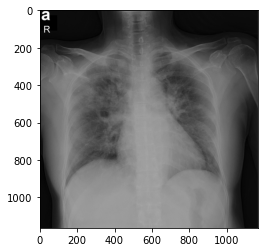

In [3]:
#visualize an image in the training set
train_list = []
for image_path in glob.glob(train_img_dir + "/*"):
    img = Image.open(image_path)
    train_list.append(img)
    
fig = plt.figure()
plt.imshow(train_list[2], cmap = "gray")

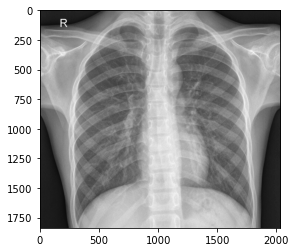

In [4]:
#Visualize an image in the test set
test_list = []
for image_path in glob.glob(test_img_dir + "/*"):
    img = Image.open(image_path)
    test_list.append(img)
    
fig = plt.figure()
plt.imshow(test_list[2], cmap = "gray")

In [5]:
print("There are " + str(len(test_list)) + " images in the test set")
print("There are " + str(len(train_list)) + " images in the training set")

There are 626 images in the test set
There are 5311 images in the training set


In [6]:
# Information about data set
df_metadata = pd.read_csv("input/Chest_xray_Corona_Metadata.csv")
df_metadata.head()

#Label column is the target column for prediction 

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [7]:
set(df_metadata["Label"])  # two label: binary classification

{'Normal', 'Pnemonia'}

In [8]:
#divide train & test metadata
train_df = df_metadata[df_metadata["Dataset_type"] == "TRAIN"]
test_df = df_metadata[df_metadata["Dataset_type"] == "TEST"]


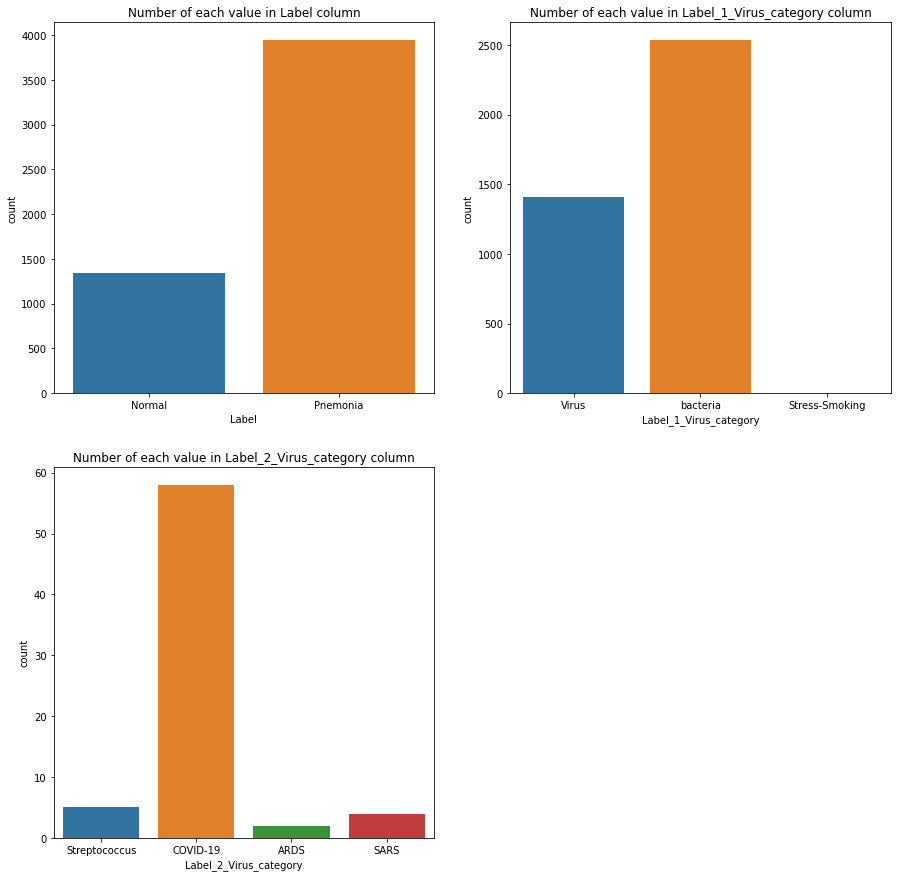

In [9]:
col = ['Label', 'Label_1_Virus_category', 'Label_2_Virus_category']

fig = plt.figure(figsize=(15, 15))
for i in range(3):
    ax = plt.subplot(2, 2, i + 1)
    ax = sns.countplot(x = col[i], data = train_df)
    ax.set_title(f'Number of each value in {col[i]} column')
plt.show()

In [10]:
train_df.fillna("unknown", inplace = True )
test_df.fillna("unknown", inplace = True )

C:\Users\nuras\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [11]:
train_df["Label_2_Virus_category"].value_counts()


unknown          5217
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64

In [12]:
train_df["Label_1_Virus_category"].value_counts()

bacteria          2535
Virus             1407
unknown           1342
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64

In [13]:
# Function creates working directories for labelled images

def create_dir():   
    try:
        os.makedirs('working/train/Pnemonia')
        os.makedirs('working/train/Normal')
        os.makedirs('working/test/Pnemonia')
        os.makedirs('working/test/Normal')
    except:
        pass

In [14]:
create_dir()  # call function

In [15]:
# Move training data with labels Pnemonia and Normal to created directiories

#COVID-19 case
train_pnemonia ='working/train/Pnemonia'
move_train_pnemonia = train_df[train_df.Label == 'Pnemonia']['X_ray_image_name'].values
for i in move_train_pnemonia:
    path = os.path.join(train_img_dir,i)
    shutil.copy(path, train_pnemonia)
    
#Normal cases 
train_normal =  'working/train/Normal'
move_train_normal = train_df[train_df.Label == 'Normal']['X_ray_image_name'].values
for i in move_train_normal:
    path = os.path.join(train_img_dir,i)
    shutil.copy(path, train_normal)

In [16]:
# Move test data with labels Pnemonia and Normal to created directiories


#COVID-19 cases
test_pnemonia = 'working/test/Pnemonia'
move_test_pnemonia = test_df[test_df.Label == 'Pnemonia']['X_ray_image_name'].values
for i in move_test_pnemonia :
    path = os.path.join(test_img_dir,i)
    shutil.copy(path,test_pnemonia)

#Normal cases
test_normal = 'working/test/Normal'
move_test_normal = test_df[test_df.Label == 'Normal']['X_ray_image_name'].values
for i in move_test_normal:
    path = os.path.join(test_img_dir,i)
    shutil.copy(path, test_normal)

In [17]:
# Model configuration
batch_size = 64
img_width, img_height, img_num_channels = 224,224,3
epochs = 15
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [18]:
#Data Augmentation

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)
train_generator = train_datagen.flow_from_directory('working/train/',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    subset = 'training')

valid_generator = train_datagen.flow_from_directory('working/train/',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    subset = 'validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('working/test/',
                                                  batch_size=batch_size,
                                                  class_mode='binary')

Found 4230 images belonging to 2 classes.
Found 1056 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [26]:
#Modelling

# include_top = False, we eliminate the fully connected layers of Resnet architecture

base_model = tf.keras.applications.ResNet50(include_top = False, weights = "imagenet", input_tensor = None,
                                           input_shape = input_shape)

base_model.trainable = False # we ignore weights of the pre-trained model


model = models.Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(layers.Dense(128))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [30]:
#add a earlystopping callback to stop the training if the model is not learning anymore
early_stopping = EarlyStopping (
min_delta = 0.001,
patience = 30,
restore_best_weights = True
)


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_generator, validation_data = valid_generator,  epochs=10, callbacks = [early_stopping])

Epoch 1/10
67/67 [==============================] - 496s 7s/step - loss: 0.7900 - accuracy: 0.6518 - val_loss: 0.5281 - val_accuracy: 0.7462
Epoch 2/10
67/67 [==============================] - 502s 7s/step - loss: 0.5386 - accuracy: 0.7522 - val_loss: 0.4905 - val_accuracy: 0.7670
Epoch 3/10
67/67 [==============================] - 507s 8s/step - loss: 0.4754 - accuracy: 0.7688 - val_loss: 0.4536 - val_accuracy: 0.7737
Epoch 4/10
67/67 [==============================] - 506s 8s/step - loss: 0.4561 - accuracy: 0.7723 - val_loss: 0.4769 - val_accuracy: 0.7538
Epoch 5/10
67/67 [==============================] - 523s 8s/step - loss: 0.5048 - accuracy: 0.7615 - val_loss: 0.4477 - val_accuracy: 0.7803
Epoch 6/10
67/67 [==============================] - 514s 8s/step - loss: 0.4511 - accuracy: 0.7788 - val_loss: 0.4308 - val_accuracy: 0.7765
Epoch 7/10
67/67 [==============================] - 509s 8s/step - loss: 0.4157 - accuracy: 0.8024 - val_loss: 0.4316 - val_accuracy: 0.7812
Epoch 8/10
67

In [31]:
model.save("model.h5") 

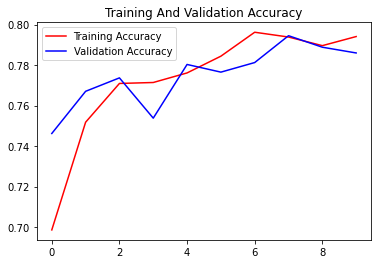

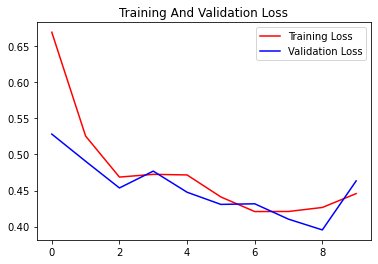

In [32]:
#learning curves

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs,acc,"r",label="Training Accuracy")
plt.plot(epochs,val_acc,"b",label="Validation Accuracy")
plt.title("Training And Validation Accuracy")

plt.legend()
plt.figure()

plt.plot(epochs,loss,"r",label="Training Loss")
plt.plot(epochs,val_loss,"b",label="Validation Loss")
plt.title("Training And Validation Loss")

plt.legend()
plt.show()

In [33]:
 #make predictions on test data, from classification report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)
y_test = test_generator.labels

print('Classification report:\n', classification_report(y_test, y_pred))
print('Accuracy score:\n', accuracy_score(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.38      1.00      0.55       234
           1       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624

Accuracy score:
 0.375


C:\Users\nuras\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
